# AppleJack ForwardSampling GT Non-Informative Priors 240K v3.0

In [100]:
import bnlearn as bn
import pgmpy as pg
from pgmpy.models import BayesianNetwork
from pgmpy.models import BayesianModel
from pgmpy.factors.discrete import TabularCPD
import networkx as nx
import matplotlib.pyplot as plt
from pgmpy.estimators import ParameterEstimator
from pgmpy.estimators import BayesianEstimator
from pgmpy.factors.discrete import TabularCPD
from pgmpy.sampling import BayesianModelSampling
from bnlearn import structure_learning
from bnlearn import parameter_learning
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [101]:
# Defining the model structure by passing a list of edges
model = BayesianModel([('LatVar1', 'Drought'),('LatVar2', 'Drought'),('Drought', 'DryFarm'), ('LatVar3', 'DryFarm'),('DryFarm', 'LowSoilMoisture'), ('LatVar4', 'LowSoilMoisture'),('LowSoilMoisture', 'DryTree'), ('DryTree', 'BadTreeCondition'), ('SickTree', 'BadTreeCondition'), ('BadTreeCondition', 'BadCropCondition'), ('LatVar5', 'BadCropCondition'), ('BadTreeCondition', 'LoseLeaves'), ('LatVar6', 'LoseLeaves')])
DAG =  bn.make_DAG(model)

[bnlearn] >No changes made to existing bayes DAG.


[bnlearn] >Set node properties.
[bnlearn] >Set edge properties.
[bnlearn] >Plot based on Bayesian model


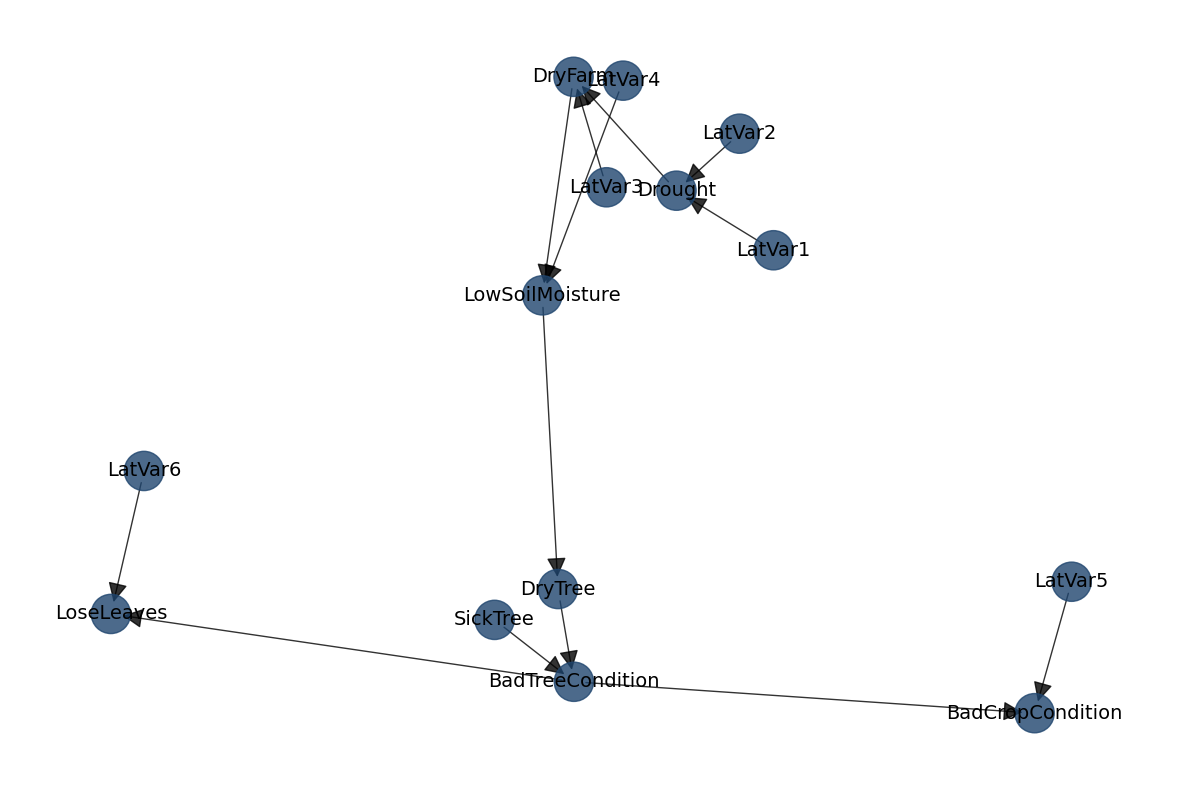

{'pos': {'LatVar1': array([0.33096856, 0.14254334]),
  'Drought': array([0.13601656, 0.20253977]),
  'LatVar2': array([0.26272938, 0.259946  ]),
  'DryFarm': array([-0.0706999,  0.3172097]),
  'LatVar3': array([-0.0045683 ,  0.20595744]),
  'LowSoilMoisture': array([-0.13342194,  0.09711636]),
  'LatVar4': array([0.02879737, 0.31335762]),
  'DryTree': array([-0.10188974, -0.19862454]),
  'BadTreeCondition': array([-0.07002142, -0.29202287]),
  'SickTree': array([-0.22932451, -0.22968717]),
  'BadCropCondition': array([ 0.85532541, -0.32365339]),
  'LatVar5': array([ 0.92964175, -0.19126684]),
  'LoseLeaves': array([-1.        , -0.22370501]),
  'LatVar6': array([-0.93355323, -0.07971041])},
 'G': <networkx.classes.digraph.DiGraph at 0x7f9d0f92d180>,
 'node_properties': {'LatVar1': {'node_color': '#1f456e', 'node_size': 800},
  'Drought': {'node_color': '#1f456e', 'node_size': 800},
  'LatVar2': {'node_color': '#1f456e', 'node_size': 800},
  'DryFarm': {'node_color': '#1f456e', 'node_si

In [102]:
#Plot BN representing Directed Acycling Graph - DAG
bn.plot(DAG)

In [103]:
# Defining all the conditional probabilities tables by a method in pgmpy called TabularCPD
cpd_ltv1 = TabularCPD(variable='LatVar1', variable_card=2, values=[[0.9000],[0.1000]])
cpd_ltv2 = TabularCPD(variable='LatVar2', variable_card=2, values=[[0.4000],[0.6000]])
cpd_ltv3 = TabularCPD(variable='LatVar3', variable_card=2, values=[[0.2000],[0.8000]])
cpd_ltv4 = TabularCPD(variable='LatVar4', variable_card=2, values=[[0.4500],[0.5500]])
cpd_ltv5 = TabularCPD(variable='LatVar5', variable_card=2, values=[[0.2000],[0.8000]])
cpd_ltv6 = TabularCPD(variable='LatVar6', variable_card=2, values=[[0.6000],[0.4000]])

## Representation of CPD in pgmpy, the columns are the evidence and rows are the states of the variable. 
#represents P(grade|diff, intel) 

cpd_dr = TabularCPD(variable='Drought', variable_card=2, 
                    values=[[0.9000, 0.6000, 0.4000, 0.1000],
                            [0.1000, 0.4000, 0.6000, 0.9000]],
                    evidence=['LatVar1','LatVar2'],
                    evidence_card=[2, 2])

cpd_df = TabularCPD(variable='DryFarm', variable_card=2, 
                    values=[[0.9000, 0.8000, 0.2000, 0.1000],
                            [0.1000, 0.2000, 0.8000, 0.9000]],
                    evidence=['Drought', 'LatVar3'],
                    evidence_card=[2, 2])

cpd_lsm = TabularCPD(variable='LowSoilMoisture', variable_card=2, 
                    values=[[0.6500, 0.2000, 0.8000, 0.3500],
                            [0.3500, 0.8000, 0.2000, 0.6500]],
                    evidence=['DryFarm', 'LatVar4'],
                    evidence_card=[2, 2])

cpd_dt = TabularCPD(variable='DryTree', variable_card=2, 
                    values=[[0.7500, 0.2500],
                            [0.2500, 0.7500]],
                    evidence=['LowSoilMoisture'],
                    evidence_card=[2])

cpd_st = TabularCPD(variable='SickTree', variable_card=2, values=[[0.7051], [0.2949]])

cpd_btc = TabularCPD(variable='BadTreeCondition', variable_card=2, 
                    values=[[0.7500, 0.6000, 0.4000, 0.2500],
                            [0.2500, 0.4000, 0.6000, 0.7500]],
                    evidence=['DryTree','SickTree'],
                    evidence_card=[2, 2])

cpd_bcc = TabularCPD(variable='BadCropCondition', variable_card=2, 
                    values=[[0.7000, 0.6000, 0.4000, 0.3000],
                            [0.3000, 0.4000, 0.6000, 0.7000]],
                    evidence=['BadTreeCondition', 'LatVar5'],
                    evidence_card=[2, 2])

cpd_ll = TabularCPD(variable='LoseLeaves', variable_card=2, 
                    values=[[0.7500, 0.3500, 0.6500, 0.2500 ],
                            [0.2500, 0.6500, 0.3500, 0.7500]],
                    evidence=['BadTreeCondition', 'LatVar6'],
                    evidence_card=[2, 2])

In [104]:
# Add the conditional probability tables to the model
model.add_cpds(cpd_ltv1, cpd_ltv2, cpd_ltv3, cpd_ltv4, cpd_ltv5, cpd_ltv6, cpd_dr, cpd_df, cpd_lsm, cpd_dt, cpd_st, cpd_btc, cpd_bcc, cpd_ll)

In [105]:
# Check if the model is valid
model.check_model()

True

In [106]:
# Create a BayesianModelSampling object with the model
sampler = BayesianModelSampling(model)

In [107]:
# Use Bayesian Parameter Estimation to refine the parameter estimates
# Set the number of samples and Dirichlet hyperparameters
n = 240000

In [108]:
# Generate 240000 samples from the model using forward sampling
samples = sampler.forward_sample(size=240000)

  0%|          | 0/14 [00:00<?, ?it/s]

In [109]:
# Convert the samples to DataFrame format
samples_df = pd.DataFrame(samples)

In [110]:
print(samples_df)

        LatVar1  Drought  LatVar2  DryFarm  LatVar3  LowSoilMoisture  LatVar4  \
0             0        0        0        0        0                1        1   
1             0        1        1        1        1                1        1   
2             0        0        1        0        0                1        0   
3             1        0        0        0        1                1        1   
4             0        0        1        0        1                1        1   
...         ...      ...      ...      ...      ...              ...      ...   
239995        1        1        0        1        1                0        1   
239996        0        0        0        0        0                0        0   
239997        0        1        1        1        1                0        1   
239998        0        1        1        1        1                1        1   
239999        1        0        0        0        1                1        1   

        DryTree  BadTreeCon

In [111]:
df = samples_df

In [112]:
# Write the DataFrame to a CSV file
df.to_csv('AppleJack_ForwardSampling_GT_240000.csv', index=False)

In [113]:
from sklearn.model_selection import train_test_split

In [114]:
# Load the dataset
data = pd.read_csv('AppleJack_ForwardSampling_GT_240000.csv')  

In [115]:
# Splitting the data into training (70%) and validation (30%) sets
GT240000_train_data, GT240000_val_data = train_test_split(data, test_size=0.3, random_state=42)

# Check the sizes to verify the split
print("Training set size:", GT240000_train_data.shape)
print("Validation set size:", GT240000_val_data.shape)


Training set size: (168000, 14)
Validation set size: (72000, 14)


In [116]:
# Print the sizes of the subsets
print("Train Data:", GT240000_train_data.shape)
print("Validation Data:", GT240000_val_data.shape)

Train Data: (168000, 14)
Validation Data: (72000, 14)


In [117]:
# Save the split datasets to CSV files
GT240000_train_data.to_csv("GT168000_train_data.csv")
GT240000_val_data.to_csv("GT72000_val_data.csv")